In [1]:
from sklearn.ensemble import RandomForestRegressor
import random

import sys
sys.path.append("../..")

from src.data_loaders import get_wake_datasets
from src.evaluation import evaluate_model
import src.plotting as plotting

In [2]:
FACTORS_FOLDER = "discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01"
DATA_FOLDER = f"../data/{FACTORS_FOLDER}/"
CONSIDER_WS = False
COORDS_AS_INPUT = True  # univariate setting
# INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR = {'ti': 4, 'ct': 4}
# train_reduc_factor_string = "training_factors=" + "-".join([f"{k}{v}" for k, v in INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR.items()])
INPUT_VAR_TO_TRAIN_RANGES = {"ti": [(0.15, 0.4)], "ct": [(0.3, 0.7)]}
train_range_string = "training_ranges=" + "-".join(
    [
        f"{var}{r[0]}-{r[1]}"
        for var, ranges in INPUT_VAR_TO_TRAIN_RANGES.items()
        for r in ranges
    ]
)
MAX_DEPTH = None

MODEL_NAME = f"univariate_RF_max-depth{MAX_DEPTH}_{train_range_string}"
if CONSIDER_WS:
    MODEL_NAME += "_consider_ws"
MODEL_DESCRIPTION = MODEL_NAME + "_" + FACTORS_FOLDER
print(MODEL_NAME)

univariate_RF_max-depthNone_training_ranges=ti0.15-0.4-ct0.3-0.7


In [3]:
train_dataset, valid_dataset, test_dataset = get_wake_datasets(
    DATA_FOLDER,
    consider_ws=CONSIDER_WS,
    coords_as_input=COORDS_AS_INPUT,
    # train_perc=0.6,
    # validation_perc=0.2,
    # test_perc=0.2
    input_var_to_train_ranges=INPUT_VAR_TO_TRAIN_RANGES,
)

train_x, train_y = train_dataset.inputs, train_dataset.outputs
print("Train shapes: ", train_x.shape, train_y.shape)

grid_size = train_dataset.num_cells
print(f"{grid_size=}")

/Users/niccolomorabito/Library/CloudStorage/GoogleDrive-morabito.1808746@studenti.uniroma1.it/My Drive/BDMA/Semester4 Thesis/Ainslie-surrogate/utils/data_loaders.py:241: UserWarning: 
Ignoring percentages of train-valid-test split (train_perc=0.8, valid_perc=0, test_perc=0.2)
and using the following ranges for the training set instead:
{'ti': [(0.15, 0.4)], 'ct': [(0.3, 0.7)]}
  warnings.warn(


Train shapes:  torch.Size([7347200, 4]) torch.Size([7347200, 1])
grid_size=7168


In [4]:
train_x, train_y = train_dataset.inputs, train_dataset.outputs
print("Train shapes: ", train_x.shape, train_y.shape)
train_size = train_x.shape[0]

test_x, test_y = test_dataset.inputs, test_dataset.outputs
print("Test shapes: ", test_x.shape, test_y.shape)
test_size = test_x.shape[0]

valid_x, valid_y = valid_dataset.inputs, valid_dataset.outputs
print("Valid shapes: ", valid_x.shape, valid_y.shape)
valid_size = valid_x.shape[0]

size = train_size + test_size + valid_size
print(train_size / size, test_size / size, valid_size / size)

Train shapes:  torch.Size([7347200, 4]) torch.Size([7347200, 1])
Test shapes:  torch.Size([27145216, 4]) torch.Size([27145216, 1])
Valid shapes:  torch.Size([27152384, 4]) torch.Size([27152384, 1])
0.11918604651162791 0.44034883720930235 0.44046511627906976


# Training

In [5]:
model = RandomForestRegressor(max_depth=MAX_DEPTH)
model.fit(train_x, train_y)
# tree_text = export_text(model)
# print(tree_text)

/var/folders/9c/3x13fm0x7034gf06x85_2t180000gn/T/ipykernel_7520/3190110263.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


: 

: 

In [ ]:
importances = model.feature_importances_
for featurenum, importance in enumerate(importances):
    featurename = train_dataset.featurenum_to_featurename(featurenum)
    print(f"{featurename} feature importance={importance}")

ti feature importance=0.21688262845160872
ct feature importance=0.20351479735964484
x/D feature importance=0.15051434915161818
y/D feature importance=0.4290882250371284


In [ ]:
# evaluation on trainset
evaluate_model(
    model,
    data=(train_x, train_y),
    data_type="train",
    model_description=MODEL_DESCRIPTION,
    save_results=True,
)

print("\n")

# evalution on testset
evaluate_model(
    model,
    data=(test_x, test_y),
    data_type="test",
    model_description=MODEL_DESCRIPTION,
    save_results=True,
)

Train results for univariate_RF_max-depthNone_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01


r2_score=0.9999689318587138
explained_variance_score=0.9999689511638187
mean_squared_error=3.862803028689581e-08
mean_absolute_error=3.253030553984729e-05
median_absolute_error=4.00312710553425e-07
mean_absolute_percentage_error=0.008341417522290413
Prediction time=2.5231655832234914e-05s


Test results for univariate_RF_max-depthNone_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01
r2_score=0.9935996105293525
explained_variance_score=0.9936075938610812
mean_squared_error=7.176972062711811e-06
mean_absolute_error=0.0009501458103107368
median_absolute_error=0.0003491546958684921
mean_absolute_percentage_error=0.08100405982004563
Prediction time=1.3526955523595095e-05s


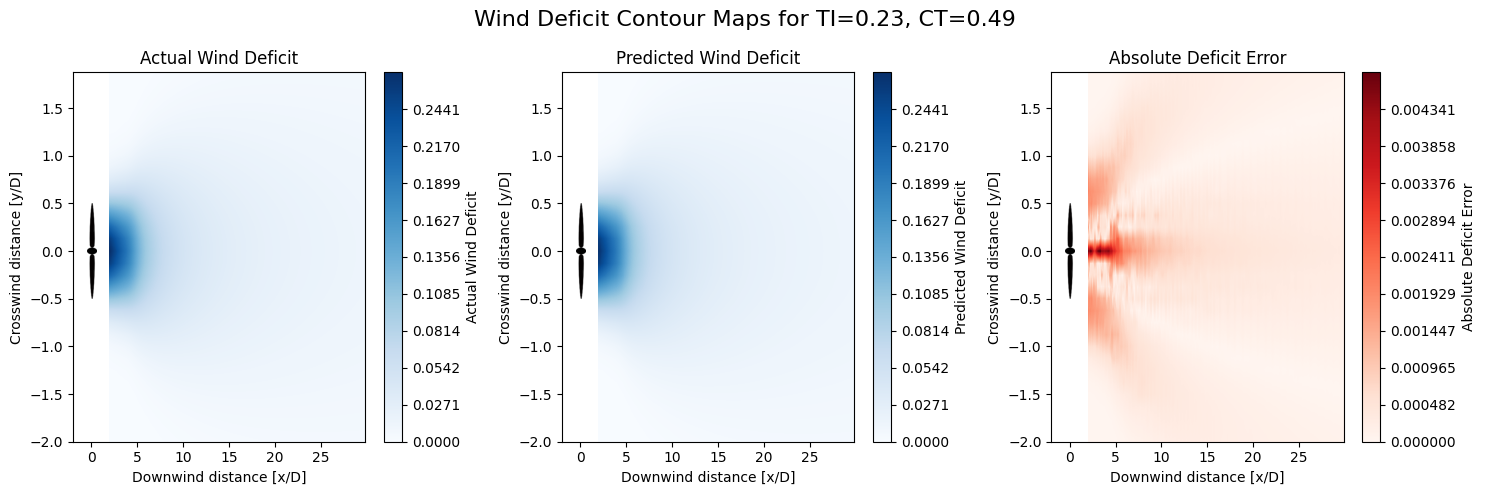

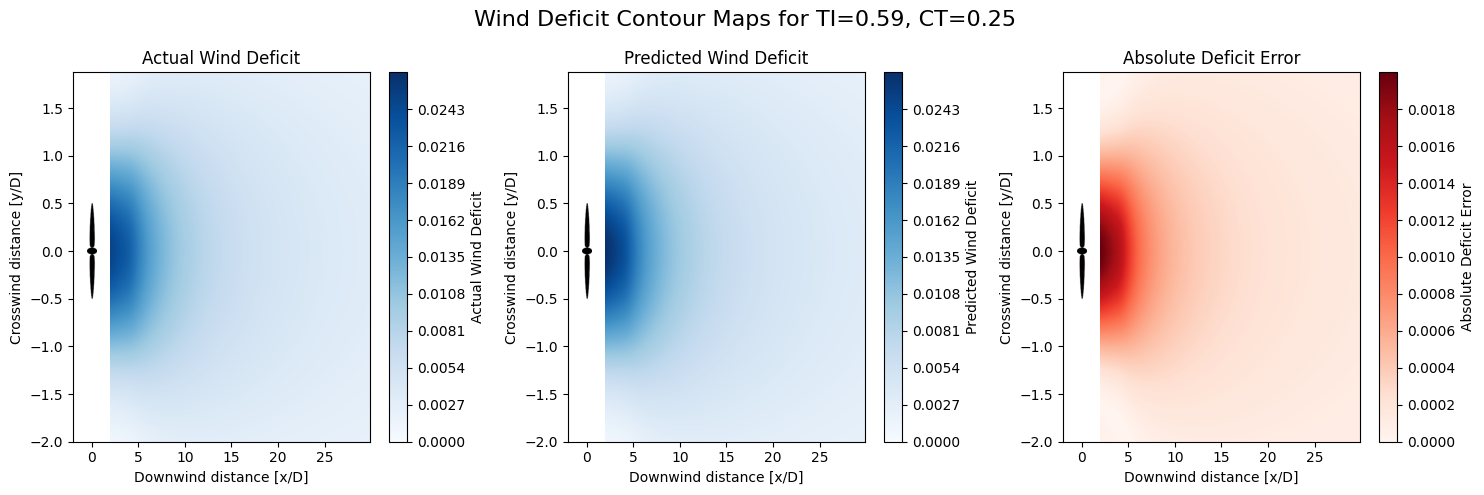

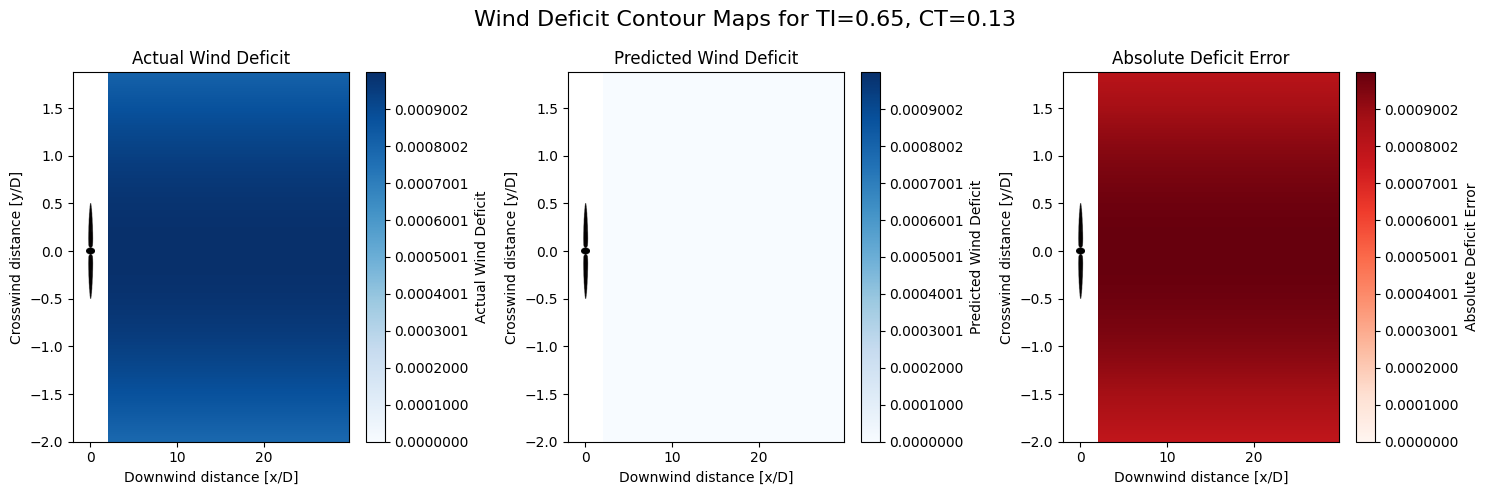

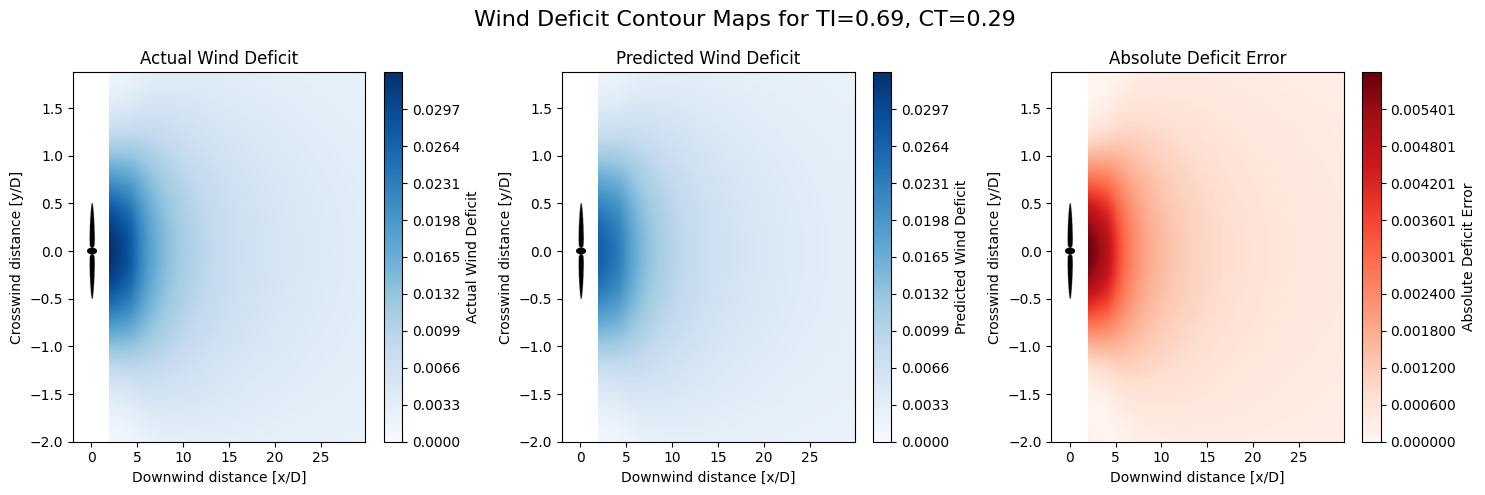

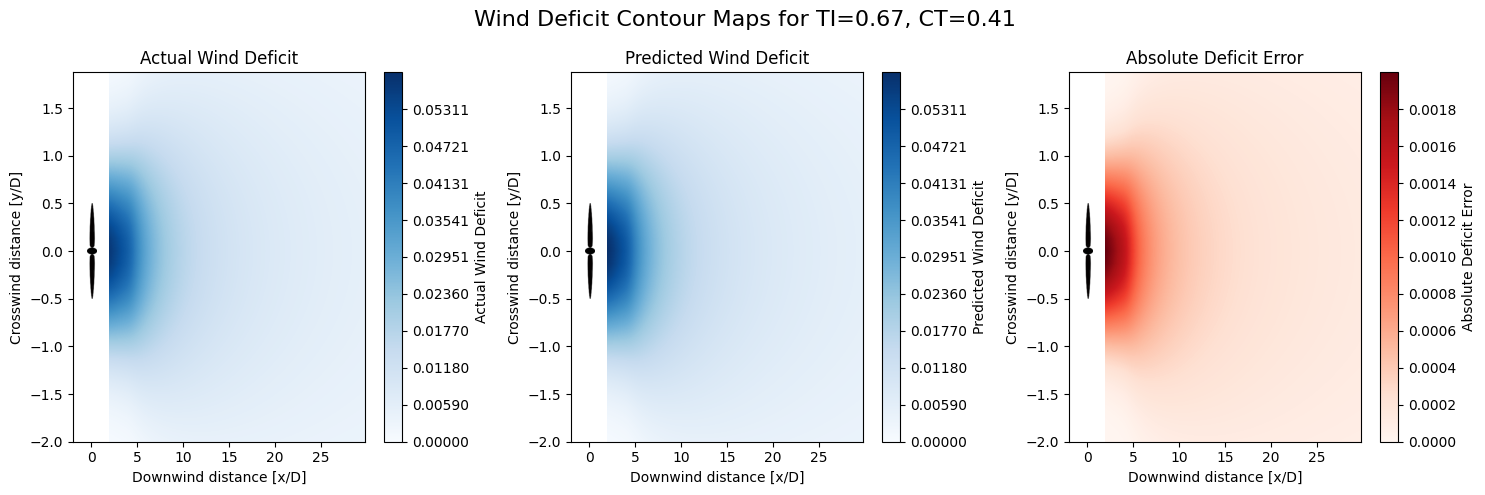

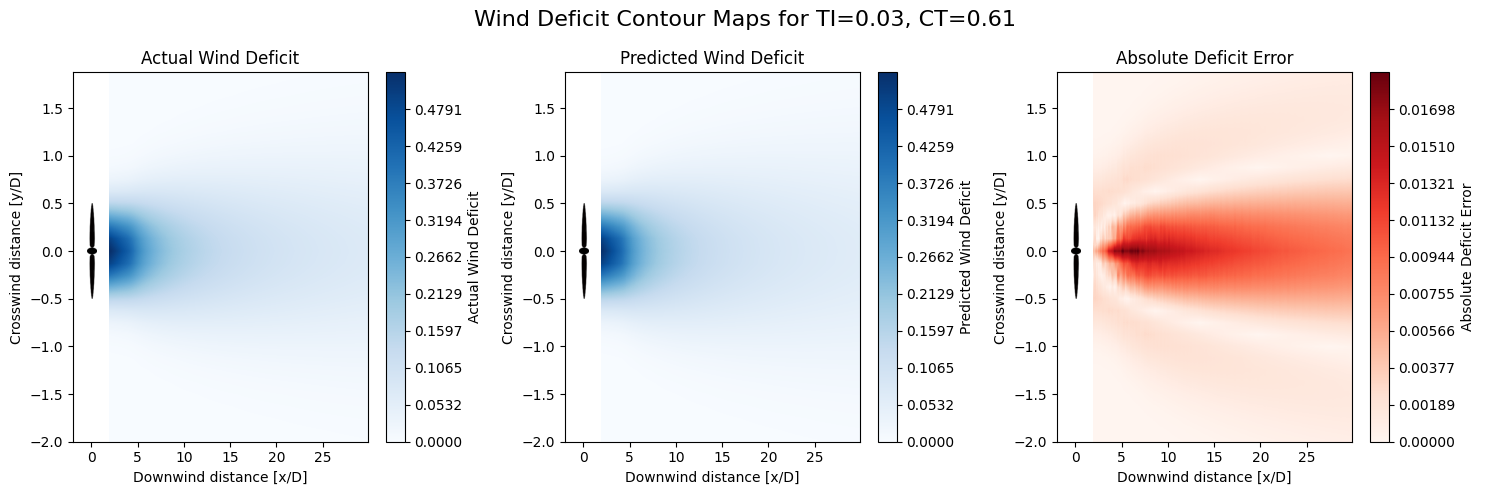

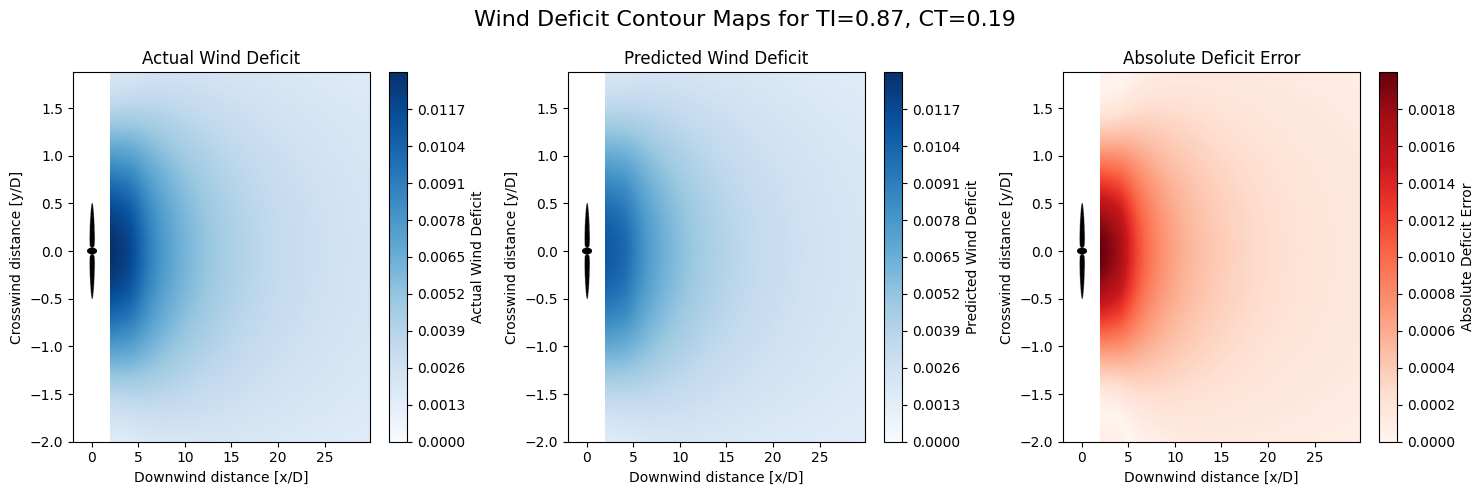

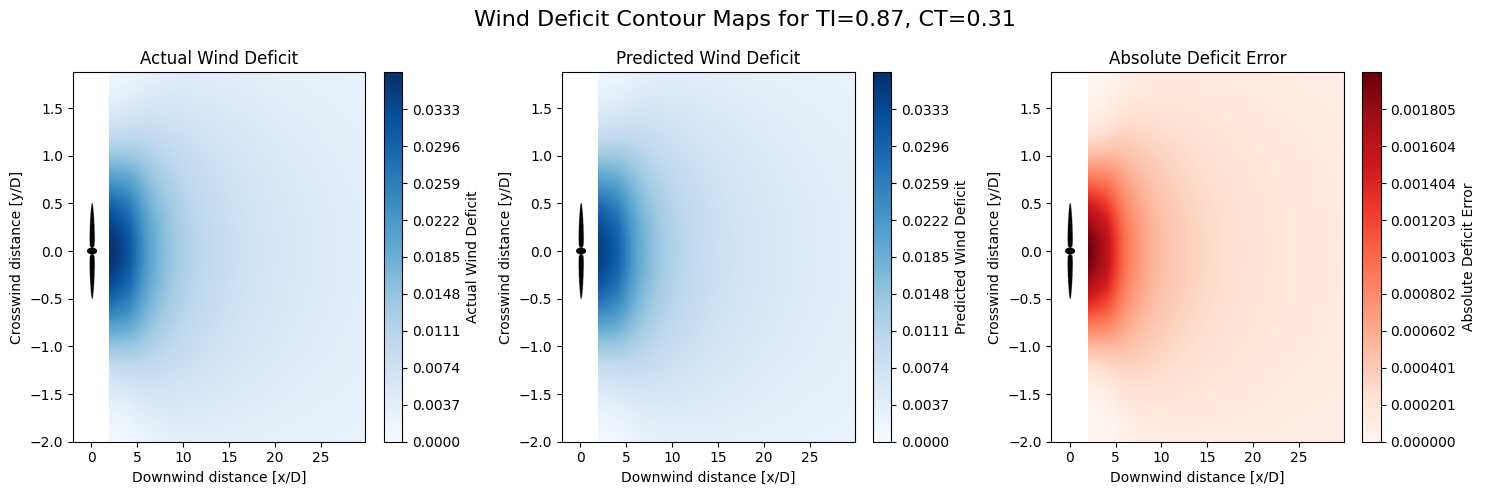

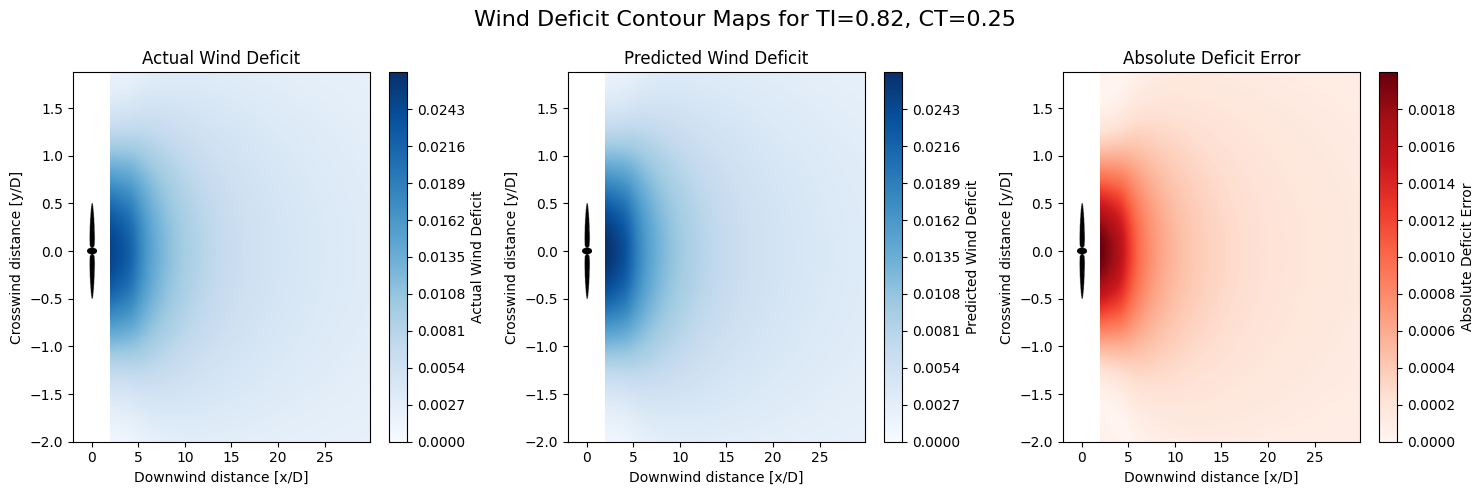

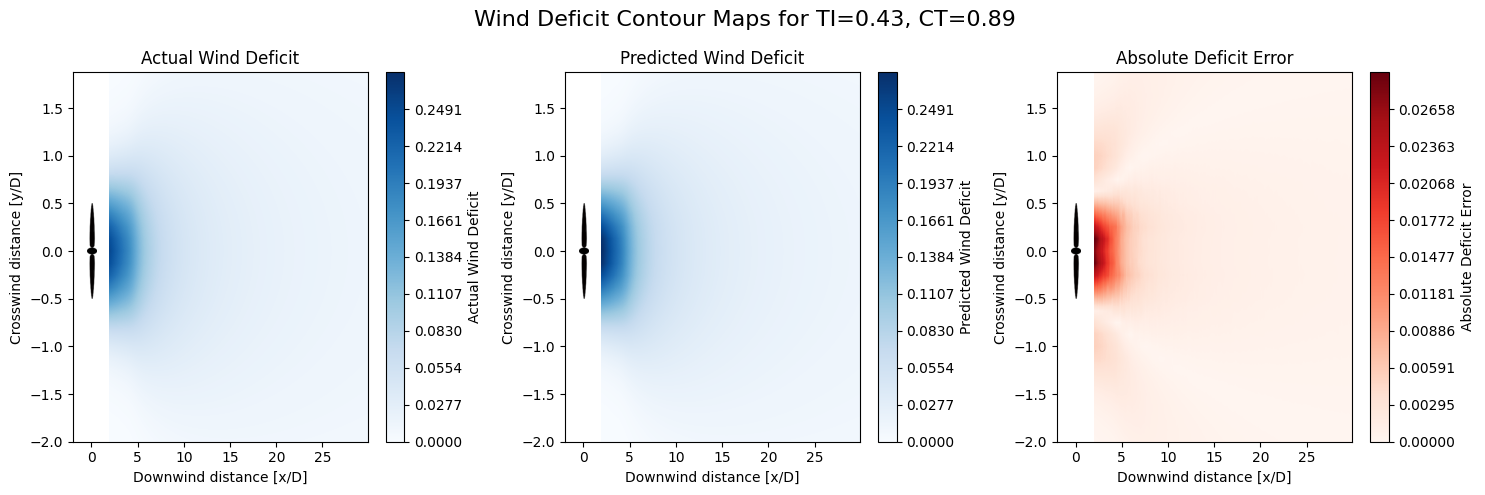

In [ ]:
num_cells = test_dataset.num_cells
num_fields = len(test_dataset) // num_cells
field_indices = list(range(num_fields))
random.shuffle(field_indices)

for field_idx in field_indices[:10]:
    ti, ct, ws, wake_field, predicted_wake_field = (
        test_dataset.get_parameters_for_plotting_univariate(model, field_idx)
    )
    plotting.plot_maps(
        test_dataset.X_grid,
        test_dataset.Y_grid,
        wake_field,
        predicted_wake_field,
        ti,
        ct,
        ws,
        error_to_plot="absolute",
    )